In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### __***Image Display Function***__

In [ ]:
#to display images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path, size = (5,5)):
    img = mpimg.imread(image_path)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# __***Data Preprocessing***__

##### __1. Converting all images to the same file format for uniformity__
##### __2. Removing invalid file format images__
##### __3. Removing highly noisy images__

In [ ]:
#Data preprocessing

import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError

dataset_path = "/content/drive/MyDrive/Mini Project Plant Disease/Apple data"
output_path = "/content/drive/MyDrive/Mini Project Plant Disease/Preprocessed"

os.makedirs(output_path, exist_ok=True)

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

def is_black_or_white_image(image):
    if np.all(image == 0) or np.all(image == 255):
        return True
    return False

def is_noisy_image(image, threshold=5.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy < threshold

def process_images():
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        output_class_path = os.path.join(output_path, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            file_ext = os.path.splitext(img_name)[1].lower()

            if file_ext not in valid_extensions:
                print(f"Skipping incompatible file: {img_path}")
                continue

            try:
                image = Image.open(img_path).convert("RGB")
                image_cv = cv2.imread(img_path)

                if image_cv is None:
                    print(f"Removing unreadable image: {img_path}")
                    continue

                if is_black_or_white_image(image_cv) or is_noisy_image(image_cv):
                    print(f"Removing invalid image: {img_path}")
                    continue

                new_img_name = os.path.splitext(img_name)[0] + ".jpg"
                new_img_path = os.path.join(output_class_path, new_img_name)
                image.save(new_img_path, "JPEG")

            except UnidentifiedImageError:
                print(f"Skipping non-image file: {img_path}")
                continue
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    print("Dataset cleaned and converted to .jpg format")

process_images()

Processing Apple___Black_rot: 100%|██████████| 621/621 [00:31<00:00, 19.51it/s]

Dataset cleaned and converted to .jpg format


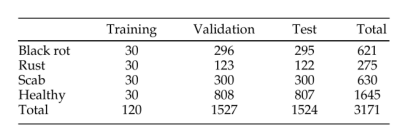

In [ ]:
display_image("/content/drive/MyDrive/Mini Project Plant Disease/Images/Dataset Split.png")

# __***Train-Validation-Test Split In Directory***__

```plaintext
Initial
└───Apple data
    ├───Scab
    ├───Black_rot
    ├───Rust
    └───Healthy

Final
├───test
│   ├───Scab
│   ├───Black_rot
│   ├───Rust
│   └───Healthy
├───train
│   ├───scab
│   ├───Black_rot
│   ├───Rust
│   └───Healthy
└───val
    ├───Scab
    ├───Black_rot
    ├───Rust
    └───Healthy
```

In [ ]:
#Train-Validation-Test split

import os
import shutil
import random

dataset_path = "/content/drive/MyDrive/Mini Project Plant Disease/Preprocessed"
output_path = "/content/drive/MyDrive/Mini Project Plant Disease/Final Dataset"

split_counts = {
    "Black_rot": {"train": 30, "val": 296, "test": 295},
    "Rust": {"train": 30, "val": 123, "test": 122},
    "Scab": {"train": 30, "val": 300, "test": 300},
    "Healthy": {"train": 30, "val": 808, "test": 807}
}

for split in ["train", "val", "test"]:
    for class_name in split_counts.keys():
        os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

for class_name, counts in split_counts.items():
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    random.shuffle(images)

    train_images = images[:counts["train"]]
    val_images = images[counts["train"]:counts["train"] + counts["val"]]
    test_images = images[counts["train"] + counts["val"]:]

    for img, split in zip([train_images, val_images, test_images], ["train", "val", "test"]):
        for image in img:
            src = os.path.join(class_path, image)
            dest = os.path.join(output_path, split, class_name, image)
            shutil.copy(src, dest)

print("Dataset successfully split and saved!")

Dataset successfully split and saved!


# __***Model Training***__

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import OrderedDict

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


# __***Hyperparameters & Connecting to GPU (if available)***__

In [ ]:
#hyper parameters
num_classes = 4
batch_size = 16
learning_rate = 0.0002
num_epochs = 50
input_size = 299
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# __***Data Agumentation***__

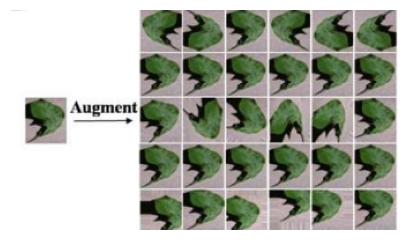

In [ ]:
display_image("/content/drive/MyDrive/Mini Project Plant Disease/Images/Data Agumentation.png")

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation(90), #random rotation
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), scale=(0.7, 1.3), shear=0.3), #random shear
    transforms.RandomHorizontalFlip(), #random horizontal flip
    transforms.RandomVerticalFlip(), #random vertical flip
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dir = '/content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/train'
val_dir = '/content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/val'

train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=2)

val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False, num_workers=2)

# __***Transfer Learning - Using Pre-trained InceptionV3 Model***__

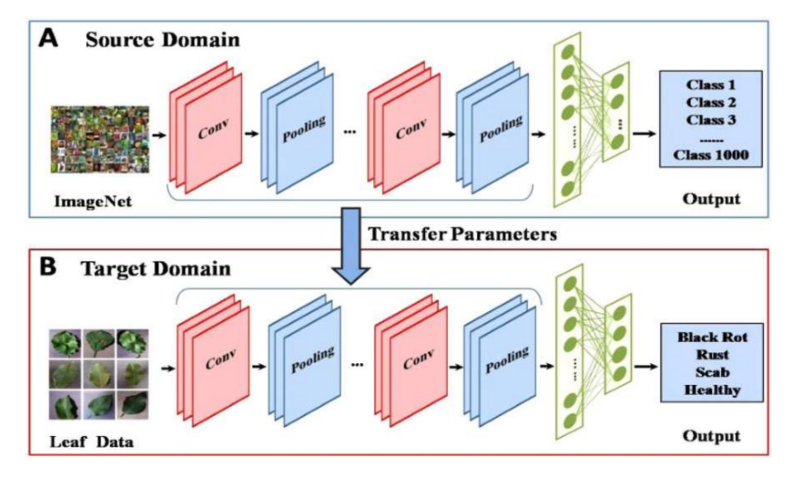

In [ ]:
display_image("/content/drive/MyDrive/Mini Project Plant Disease/Images/Transfer Learning.png", (10, 10))

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124
Epoch 1/50
Train Loss: 0.0888, Accuracy: 0.6341
Val Loss: 0.0440, Accuracy: 0.8251
Epoch 2/50
Train Loss: 0.0204, Accuracy: 0.9350
Val Loss: 0.0196, Accuracy: 0.8874
Epoch 3/50
Train Loss: 0.0072, Accuracy: 0.9837
Val Loss: 0.0081, Accuracy: 0.9561
Epoch 4/50
Train Loss: 0.0041, Accuracy: 0.9837
Val Loss: 0.0077, Accuracy: 0.9561
Epoch 5/50
Train Loss: 0.0023, Accuracy: 1.0000
Val Loss: 0.0083, Accuracy: 0.9515
Epoch 6/50
Train Loss: 0.0022, Accuracy: 0.9919
Val Loss: 0.0058, Accuracy: 0.9692
Epoch 7/50
Train Loss: 0.0015, Accuracy: 1.0000
Val Loss: 0.0075, Accuracy: 0.9601
Epoch 8/50
Train Loss: 0.0019, Accuracy: 1.0000
Val Loss: 0.0104, Accuracy: 0.9404
Epoch 9/50
Train Loss: 0.0019, Accuracy: 0.9919
Val Loss: 0.0130, Accuracy: 0.9214
Epoch 10/50
Train Loss: 0.0007, Accuracy: 1.0000
Val Loss: 0.0084, Accuracy: 0.9528
Epoch 11/50
Train Loss: 0.0007, Accuracy: 1.0000
Val Loss: 0.0052, Accuracy: 0.9712
Epoch 12/50
Train Loss

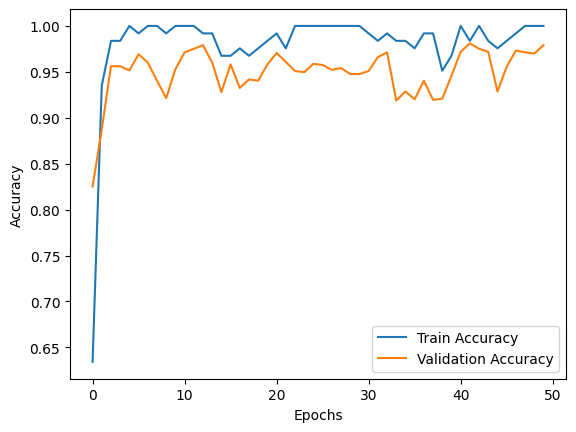

In [ ]:
#pre-trained inception v3 model

weights = models.Inception_V3_Weights.DEFAULT
model = models.inception_v3(weights=weights, aux_logits=True)

#source-target domain
model.fc = nn.Linear(model.fc.in_features, num_classes)
if model.AuxLogits is not None:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model = model.to(device)

#optimizer adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_acc_list, val_acc_list = [], []
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

#training
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_dataloader
        else:
            model.eval()
            dataloader = val_dataloader

        running_loss, correct = 0.0, 0
        total_samples = len(dataloader.dataset)

        with torch.set_grad_enabled(phase == 'train'):
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                    if phase == 'train' and model.AuxLogits is not None:
                        outputs, aux_outputs = model(images)
                        loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                running_loss += loss.item()

        epoch_loss = running_loss / total_samples
        epoch_acc = correct / total_samples

        if phase == 'train':
            train_acc_list.append(epoch_acc)
        else:
            val_acc_list.append(epoch_acc)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

save_path = "/content/drive/MyDrive/Mini Project Plant Disease/new_output/inception_v3_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

plt.plot(range(num_epochs), train_acc_list, label='Train Accuracy')
plt.plot(range(num_epochs), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Mini Project Plant Disease/new_output/accuracy_plot.png")
plt.show()

# __***Confusion Matrix on Validation data***__

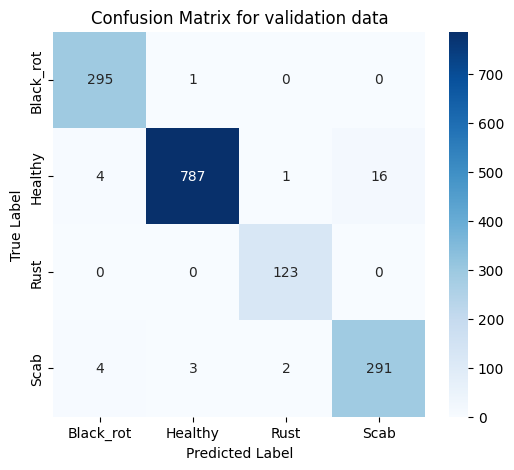

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
if model.AuxLogits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model.to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/Mini Project Plant Disease/new_output/inception_v3_model.pth"))
model.eval()

input_size = 299
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dir = "/content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/val"
val_dataset = ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

true_labels, pred_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for validation data")
plt.savefig("/content/drive/MyDrive/Mini Project Plant Disease/new_output/confusion_matrix.png")
plt.show()

# __***Calculating Metrics on Test data***__

Scanning folder: /content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/test
Checking class folder: Scab
Checking class folder: Rust
Checking class folder: Healthy
Checking class folder: Black_rot


,file,actual,predicted
0,133c27cd-57f6-4790-b446-972327e13194___FREC_Sc...,Scab,Scab
1,2e264ee0-7679-4ad2-a19a-1ac4d2e84079___FREC_Sc...,Scab,Scab
2,0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Sc...,Scab,Scab
3,a15c8e33-6b90-489e-800d-99b3056235c2___FREC_Sc...,Scab,Scab
4,13b10b04-7da6-4d34-8b43-258239a25ffd___FREC_Sc...,Scab,Scab


Predictions saved to /content/drive/MyDrive/Mini Project Plant Disease/new_output/predictions.csv

Classification Report:
              precision    recall  f1-score   support

   Black_rot       0.97      1.00      0.99       295
     Healthy       0.99      0.97      0.98       807
        Rust       1.00      1.00      1.00       122
        Scab       0.94      0.97      0.95       300

    accuracy                           0.98      1524
   macro avg       0.98      0.98      0.98      1524
weighted avg       0.98      0.98      0.98      1524

Accuracy: 0.9777


,Black_rot,Healthy,Rust,Scab
Black_rot,295,0,0,0
Healthy,6,782,0,19
Rust,0,0,122,0
Scab,2,7,0,291


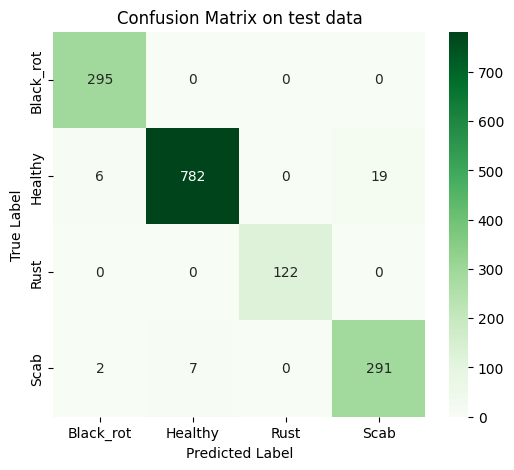

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
if model.AuxLogits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model.to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/Mini Project Plant Disease/new_output/inception_v3_model.pth", map_location=device))
model.eval()

input_size = 299
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ['Black_rot', 'Healthy', 'Rust', 'Scab']

def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).cpu().item()

    return prediction

def predict_batch(image_folder, model, transform, class_names, output_csv):
    results = []
    y_true = []
    y_pred = []

    print(f"Scanning folder: {image_folder}")

    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)

        if os.path.isdir(class_path):
            print(f"Checking class folder: {class_folder}")

            class_index = class_names.index(class_folder)

            for filename in os.listdir(class_path):
                if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                    image_path = os.path.join(class_path, filename)
                    predicted_index = predict_image(image_path, model, transform)

                    y_true.append(class_index)
                    y_pred.append(predicted_index)

                    results.append({
                        "file": filename,
                        "actual": class_names[class_index],
                        "predicted": class_names[predicted_index]
                    })

    if results:
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        display(df.head())
        print(f"Predictions saved to {output_csv}")

        evaluate_model(y_true, y_pred, class_names)

def evaluate_model(y_true, y_pred, class_names):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    df.to_csv("/content/drive/MyDrive/Mini Project Plant Disease/new_output/confusion_matrix_test.csv")
    display(df)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix on test data")
    plt.show()

image_folder = "/content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/test"
output_csv = "/content/drive/MyDrive/Mini Project Plant Disease/new_output/predictions.csv"
predict_batch(image_folder, model, transform, class_names, output_csv)

# __***Visualizing Feature maps***__

## __***Black Rot image feature maps (Model predicted correctly)***__

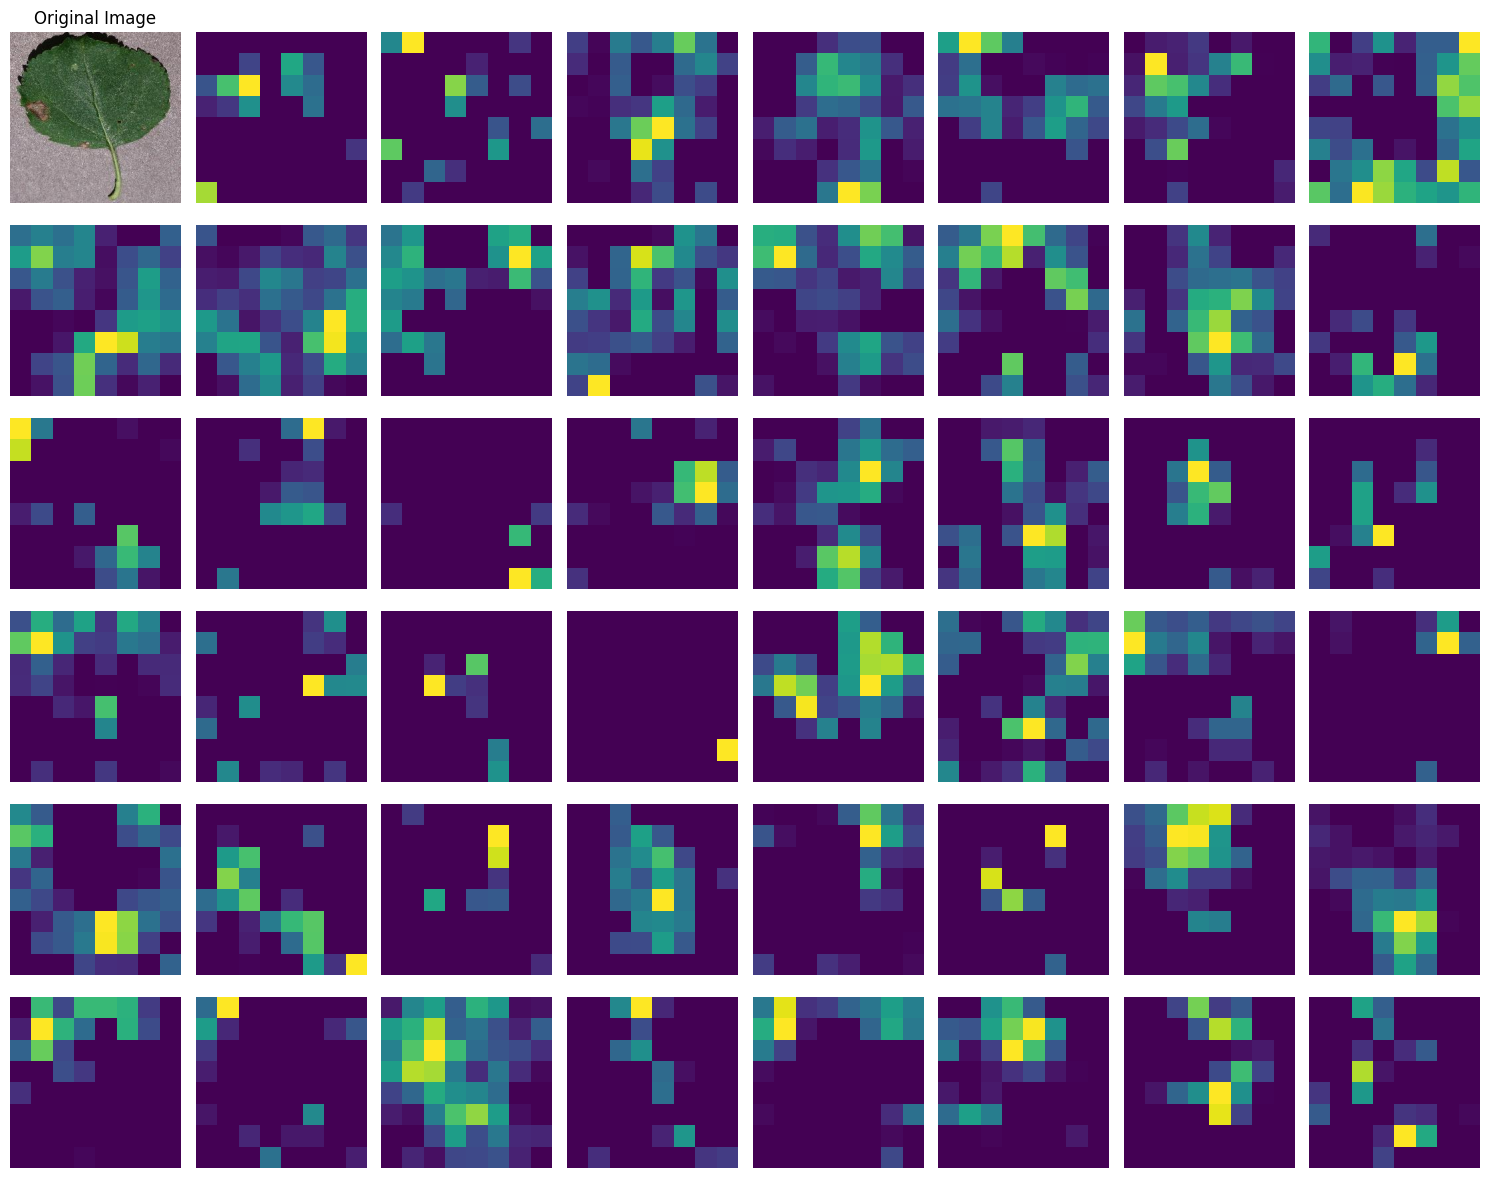

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.to(device)
model.eval()

activation = {}

def hook_fn(module, input, output):
    activation["features"] = output

model.Mixed_7c.register_forward_hook(hook_fn)

input_size = 299
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = "/content/drive/MyDrive/Mini Project Plant Disease/Mini Project Dataset/test/Black_rot/00e909aa-e3ae-4558-9961-336bb0f35db3___JR_FrgE.S 8593.JPG"
original_image = Image.open(image_path).convert("RGB")
image = transform(original_image).unsqueeze(0).to(device)

with torch.no_grad():
    model(image)

feature_map = activation["features"].cpu().squeeze()
num_features = feature_map.shape[0]

fig, axes = plt.subplots(6, 8, figsize=(15, 12))
axes[0, 0].imshow(original_image)
axes[0, 0].axis("off")
axes[0, 0].set_title("Original Image")
for i, ax in enumerate(axes.flat[1:]):
    if i < num_features:
        ax.imshow(feature_map[i].numpy(), cmap="viridis")
        ax.axis("off")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Mini Project Plant Disease/new_output/fixed_feature_maps.png")
plt.show()